In [3]:
import sys
sys.path.append("/data/home/jinyalong/git/txdas/biotech/notebook/SEV_Promoter")

from gem.models import CNN
from gem.utils import *
from gem.datasets import NPDataset
from gem.transformer import ConvBERT
from torchinfo import summary
import Levenshtein
import pandas as pd
import scipy.stats as stats
from sklearn import preprocessing
import torch
from torch import utils
from torch import nn
from torch import optim
import tqdm
set_seed(41)
device = "cuda:0"

def train(model, train_loader,test_loader,patience=3,epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
    # optimizer = optim.Adam(model.parameters(), lr=0.0033, betas=(0.9, 0.999), eps=3.43e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30)
    early_stopping = EarlyStopping(patience=patience)
    lst, vlst = [],[]
    for epoch in range(epochs):
        model.train()
        train_epoch_loss=[]
        for idx, (x, y) in tqdm.tqdm(enumerate(train_loader)):
            outputs = model(x.to(device))
            optimizer.zero_grad()
            loss = criterion(y.to(device), outputs)
            loss.backward()
            train_epoch_loss.append(loss.detach().item())
            optimizer.step()
            # scheduler.step()
        train_loss = np.average(train_epoch_loss)
        valid_epoch_loss = []
        model.eval()
        for idx, (data_x, data_y) in enumerate(test_loader):
            outputs = model(data_x.to(device))
            loss = criterion(data_y.to(device), outputs)
            valid_epoch_loss.append(loss.detach().item())
        valid_loss = np.average(valid_epoch_loss)
        print("epoch={}/{} of train, train loss={}, valid loss={}".format(epoch + 1, epochs,train_loss, valid_loss))
        lst.append(train_loss)
        vlst.append(valid_loss)

        if early_stopping.early_stop(model,valid_loss):
            break
    return early_stopping.best_model,pd.DataFrame(data={"loss":lst,"val_loss":vlst})

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    # Make predictions
    model.eval()
    predictions = model(torch.tensor(test_seq,dtype=torch.float).to(device)).reshape(-1,1).cpu().detach().numpy()
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


original_seq = 'atgggcggcgcatgagagaagcccagaccaattacctacccaaa'
original_seq=original_seq.upper()
name,seq_len,suff = "pl3-1-2",118,"" # _seq exp12-merge pl3-1-2
# datadir=f"/data/home/jinyalong/data/sev_241110/results/{name}/{name}_"
datadir=f"/data/home/jinyalong/data/sev_240624/results/{name}/{name}_"
e_train = pd.read_csv(f"{datadir}train{suff}.csv")
e_test= pd.read_csv(f"{datadir}test{suff}.csv")
e_train['distance'] = e_train.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
e_test['distance'] = e_test.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
# e_train["score"] = e_train['score_final']
# e_test["score"] = e_test['score_final']
print(e_train.shape, e_test.shape )
label="score"
batch_size= 64 # 64, 256
kernel_size = 5
set_seed(41)
train_x = one_hot_encode(e_train,seq_len=seq_len)
test_x = one_hot_encode(e_test, seq_len=seq_len)
test_y = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
tran_y = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
dataset_train = NPDataset(train_x,tran_y)
dataset_test = NPDataset(test_x,test_y)
valid_len = int(len(dataset_train)*0.1)
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset_train, [len(dataset_train)-valid_len,valid_len])
train_loader = utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valid_loader = utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=False)
test_loader = utils.data.DataLoader(dataset_test, batch_size=batch_size)
model = CNN(seq_len=seq_len,kernel_size=kernel_size)
# model = ConvBERT(in_channels=4, dim_model=128,
#                  kernel_size=kernel_size, num_heads=8,
#                  dropout_p=0.2,max_len=seq_len)
model = model.to(device)
model,pdf=train(model, train_loader, valid_loader,patience=10,epochs=40) # 10,50
# model = torch.load(f"./models/{name}.pt")
test_data(df=e_test, model=model, obs_col=label,test_seq=test_x)
r = r2(e_test['pred'],e_test["score"])
pr =  stats.pearsonr(e_test['pred'],e_test["score"] )
print(f'test {name} r-squared = ', r, "pearsonR = ", pr[0])
# torch.save(model,f"./models/{name}-{kernel_size}.pt")

(2959, 9) (156, 9)


42it [00:00, 69.24it/s]


epoch=1/40 of train, train loss=1.2851329559371585, valid loss=0.9748146414756775


42it [00:00, 85.69it/s]


epoch=2/40 of train, train loss=1.005156166496731, valid loss=0.974083137512207


42it [00:00, 80.73it/s] 


epoch=3/40 of train, train loss=1.0050175289313, valid loss=0.9732740759849549


42it [00:00, 81.25it/s]


epoch=4/40 of train, train loss=1.0049222949005308, valid loss=0.9725019812583924


42it [00:00, 86.23it/s]


epoch=5/40 of train, train loss=1.004308208113625, valid loss=0.971937608718872


42it [00:00, 66.02it/s]


epoch=6/40 of train, train loss=1.0029177651518868, valid loss=0.9713876366615295


42it [00:00, 64.83it/s]


epoch=7/40 of train, train loss=1.0034386473042625, valid loss=0.9709483623504639


42it [00:00, 87.15it/s] 


epoch=8/40 of train, train loss=1.0034165297235762, valid loss=0.9705998063087463


42it [00:00, 68.03it/s]


epoch=9/40 of train, train loss=1.004401710771379, valid loss=0.9703594207763672


42it [00:00, 75.83it/s]


epoch=10/40 of train, train loss=1.004851085799081, valid loss=0.9700883030891418


42it [00:00, 75.21it/s]


epoch=11/40 of train, train loss=1.0031405956972212, valid loss=0.9700317144393921


42it [00:00, 104.74it/s]


epoch=12/40 of train, train loss=1.0038242936134338, valid loss=0.9699057340621948


42it [00:00, 77.53it/s]


epoch=13/40 of train, train loss=1.0004055698712666, valid loss=0.9697238683700562


42it [00:00, 73.00it/s]


epoch=14/40 of train, train loss=1.0025574564933777, valid loss=0.9697071671485901


42it [00:00, 85.96it/s]


epoch=15/40 of train, train loss=1.005000270548321, valid loss=0.9697360396385193


42it [00:00, 91.49it/s] 


epoch=16/40 of train, train loss=1.0038113693396251, valid loss=0.9696067333221435


42it [00:00, 76.51it/s]


epoch=17/40 of train, train loss=1.0001938328856514, valid loss=0.9696069121360779


42it [00:00, 78.16it/s]


epoch=18/40 of train, train loss=1.0070317671412514, valid loss=0.9696030855178833


42it [00:00, 72.12it/s]


epoch=19/40 of train, train loss=1.0029594089303697, valid loss=0.9695780396461486


42it [00:00, 79.92it/s]


epoch=20/40 of train, train loss=1.0037410670802707, valid loss=0.9696165204048157


42it [00:00, 71.94it/s]


epoch=21/40 of train, train loss=1.0001362150623685, valid loss=0.9695307016372681


42it [00:00, 81.03it/s] 


epoch=22/40 of train, train loss=1.0022352153346652, valid loss=0.9695033311843873


42it [00:00, 87.25it/s]


epoch=23/40 of train, train loss=1.0007331782863254, valid loss=0.9695208311080933


42it [00:00, 82.51it/s]


epoch=24/40 of train, train loss=1.0057542636280967, valid loss=0.9695613861083985


42it [00:00, 85.93it/s]


epoch=25/40 of train, train loss=1.0028520879291354, valid loss=0.9695392370223999


42it [00:00, 81.84it/s]


epoch=26/40 of train, train loss=1.0020345548788707, valid loss=0.9695400476455689


42it [00:00, 70.14it/s]


epoch=27/40 of train, train loss=1.0027710170972914, valid loss=0.9694765329360961


42it [00:00, 75.13it/s]


epoch=28/40 of train, train loss=1.0042964276813326, valid loss=0.9695747375488282


42it [00:00, 77.78it/s]


epoch=29/40 of train, train loss=1.0044580683821724, valid loss=0.9695441484451294


42it [00:00, 59.40it/s]


epoch=30/40 of train, train loss=1.0020924097015744, valid loss=0.9694900155067444


42it [00:00, 77.98it/s]


epoch=31/40 of train, train loss=1.0024078133560361, valid loss=0.9694714665412902


42it [00:00, 80.08it/s]


epoch=32/40 of train, train loss=1.002767977260408, valid loss=0.9695435166358948


42it [00:00, 80.62it/s]


epoch=33/40 of train, train loss=1.0019911442484175, valid loss=0.9694801092147827


42it [00:00, 84.86it/s]


epoch=34/40 of train, train loss=1.0013559616747356, valid loss=0.9695509552955628


42it [00:00, 90.83it/s] 


epoch=35/40 of train, train loss=1.0010778705279033, valid loss=0.9694816112518311


42it [00:00, 87.52it/s]


epoch=36/40 of train, train loss=1.0023348714624132, valid loss=0.9695290684700012


42it [00:00, 107.54it/s]


epoch=37/40 of train, train loss=1.0041014410200573, valid loss=0.9694468975067139


42it [00:00, 111.08it/s]


epoch=38/40 of train, train loss=1.00242803919883, valid loss=0.9695158958435058


42it [00:00, 114.64it/s]


epoch=39/40 of train, train loss=1.0018449766295296, valid loss=0.9695557832717896


42it [00:00, 100.15it/s]


epoch=40/40 of train, train loss=1.0046073993047078, valid loss=0.9695084810256958


ValueError: Cannot calculate a linear regression if all x values are identical

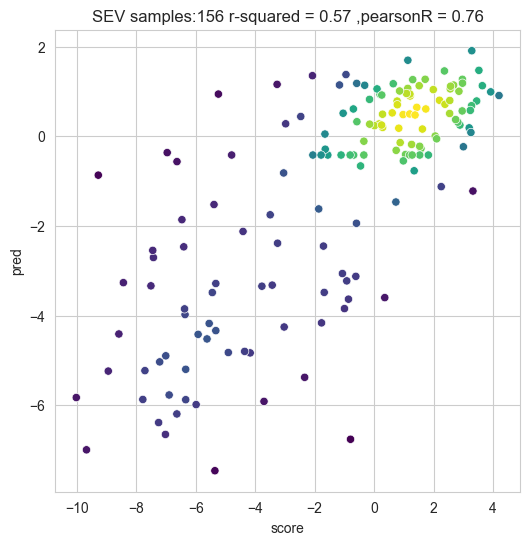

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sdf=e_test
num=len(sdf)
name = name.split("_")[0] if "_"in name else "SEV"
values = np.vstack([sdf["score"], sdf['pred']])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
plt.title(f"{name} samples:{num} r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(
    data=sdf,
    x="score",
    y="pred",
    c=kernel,
    cmap="viridis",
    ax=ax,
)

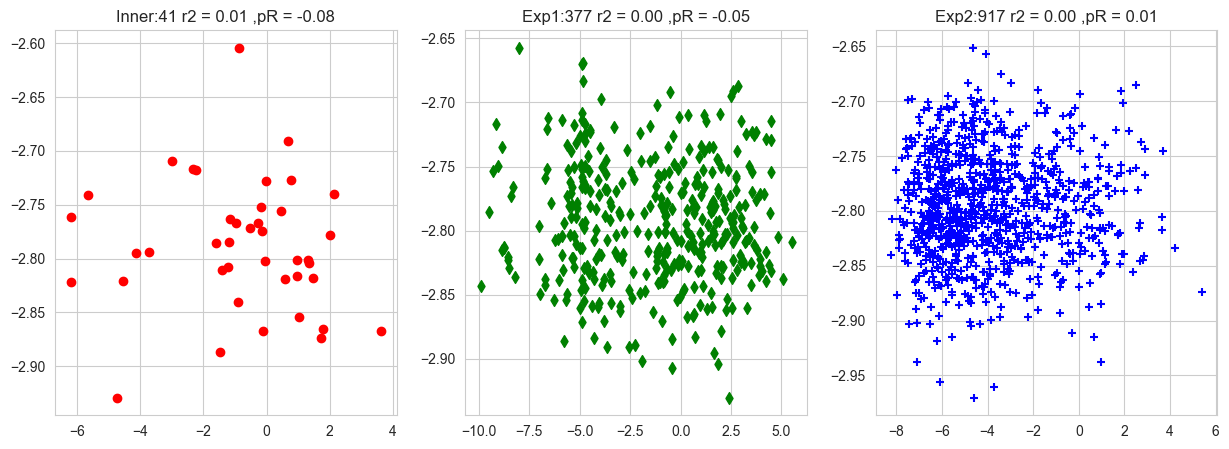

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sdf=e_test
plt.figure(figsize=(15,5))
for i in range(3):
    sdf = e_test[e_test["flag"]==i]
    plt.subplot(1,3,i+1)
    pr =  stats.pearsonr(sdf["score"],sdf["pred"])
    r = r2(sdf["score"],sdf["pred"])
    name = "Inner" if i==0 else "Exp1" if i==1 else "Exp2"
    marker = "o" if i==0 else "d" if i==1 else "+"
    color = "r" if i==0 else "g" if i==1 else "b"
    plt.title(f"{name}:{len(sdf)} r2 = {r:.2f} ,pR = {pr[0]:.2f}")
    plt.scatter(sdf["score"], sdf["pred"], marker=marker, color=color)
plt.show()


In [17]:
e_test

,seq,score,plasmid_counts,rna_counts,flag,distance,pred
0,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,1.153228,76,3315,2,77,-2.840401
1,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-0.665846,23,147,1,78,-2.830223
2,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-2.785879,38,32,2,77,-2.831995
3,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-4.733238,7,1,1,78,-2.844508
4,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-0.971419,110,574,2,78,-2.856433
...,...,...,...,...,...,...,...
1330,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCGCAGAGAGACCCAA...,2.298228,58,8603,1,78,-2.802732
1331,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACAGAGAGACCCAA...,-4.169159,28,6,2,78,-2.855979
1332,ATCCCGGGTGAGGCATCCCACCATCCTCAGTCACATAGAGACCCAA...,0.189459,1122,19157,1,78,-2.845334
1333,ATCCCGAGTGAGGCATCCCACCATCCACAATCACAGAGAGACCGAA...,1.601192,10,793,1,78,-2.777086


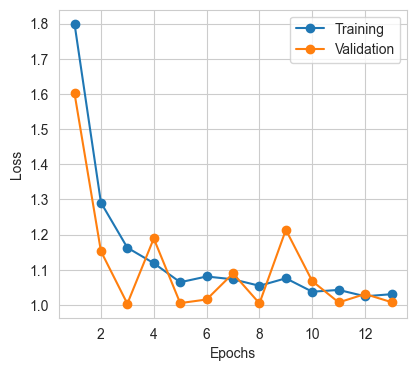

In [18]:
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import numpy
import scipy
import seaborn
# Plot training/validation losses
f, ax = pyplot.subplots(1, 1, figsize=(4.5, 4))
n_epochs_actual = len(pdf['loss'])

ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    pdf['loss'],
    marker='o',
    label='Training',
)
ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    pdf['val_loss'],
    marker='o',
    label='Validation',
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()